In [1]:
%matplotlib notebook
from matplotlib.lines import Line2D

In [2]:
#imports
from tqdm import tqdm
import time
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
import matplotlib.pylab as plt
import shutil
from matplotlib.lines import Line2D
import pandas
from sklearn.model_selection import train_test_split
%matplotlib notebook

In [24]:
all_data.keys()

dict_keys(['all', 'all_hl', 'GlarborgH2S', 'GlarborgH2S_hl', 'H_Abstraction', 'H_Abstraction_hl', 'intra_H_migration', 'intra_H_migration_hl', 'Intra_R_Add_Endocyclic', 'Intra_R_Add_Endocyclic_hl', 'Nitrogen', 'Nitrogen_hl', 'no_GlarborgH2S', 'no_GlarborgH2S_hl', 'no_H_Abstraction', 'no_H_Abstraction_hl', 'no_intra_H_migration', 'no_intra_H_migration_hl', 'no_Intra_R_Add_Endocyclic', 'no_Intra_R_Add_Endocyclic_hl', 'no_Nitrogen', 'no_Nitrogen_hl', 'no_R_Addition', 'no_R_Addition_hl', 'no_R_Recombination', 'no_R_Recombination_hl', 'R_Addition', 'R_Addition_hl', 'R_Recombination', 'R_Recombination_hl', 'reaction_list'])

In [3]:
#Load Data
family = 'all_hl'
all_data = json.load(open('./all_data.json'))
X = all_data[family]['reaction_feature_lists']
y = all_data[family]['Ea_values']

In [4]:
#Test/Train Split and choosing machines

indices = range(len(X))#random.sample(range(len(X)),5000)
Xsample = X#[X[i]for i in indices]
ysample = y

clflist = [ensemble.AdaBoostRegressor(),
           ensemble.BaggingRegressor(),
           ensemble.ExtraTreesRegressor(min_samples_split=2),
           ensemble.GradientBoostingRegressor(),
           ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",min_samples_split=2)]
x_exp, x_validation, y_exp, y_validation = train_test_split(X, y,
                                                    test_size=0.2, random_state=9)
x_validation_str = [str(i) for i in x_validation]
print("Current size of validation set : ", (len(x_validation_str)))
for i in x_validation_str:
    j = x_validation_str.index(i)

print("Size of updated validation set : ", (len(x_validation_str)))
x_train, x_test, y_train, y_test = train_test_split(x_exp, y_exp,
                                                    test_size=0.25, random_state=9)


Current size of validation set :  4164
Size of updated validation set :  4164


In [5]:
#Training  Step
results_json = {}
for clf in clflist:
        clf.fit(x_train,y_train)
        score = cross_val_score(clf,x_train,y_train,cv=5)
        score = [i for i in score]
        print(str(clf).split("(")[0]," Score 5x CV: ",score,np.mean(score))
        score_test = clf.score(x_test,y_test)
        score_train = clf.score(x_train,y_train)
        results_json.update({str(clf).split("(")[0]:{
                             "cv scores":score,
                             "cv scores mean":np.mean(score),
                             "test set score":score_test,
                             "train MAE": mean_absolute_error(y_train, clf.predict(x_train))/4184,
                             "test MAE": mean_absolute_error(y_test, clf.predict(x_test))/4184}})
#Xplot = np.polyval(p=p,x=Xplot)

AdaBoostRegressor  Score 10x CV:  [0.30155854636944623, 0.40391674625056784, 0.23364767801867037, 0.29222207343046047, 0.20567523085299733] 0.28740405498442845
BaggingRegressor  Score 10x CV:  [0.8587726989734705, 0.8553118125505411, 0.8609733985899672, 0.8679121868283075, 0.846411093698574] 0.857876238128172


/home/marque42/anaconda3/envs/equenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesRegressor  Score 10x CV:  [0.8709013690603278, 0.876739509154383, 0.8831121674698434, 0.9024272917847618, 0.8785513718209971] 0.8823463418580626
GradientBoostingRegressor  Score 10x CV:  [0.7749633298311513, 0.7634484845749073, 0.7585896003762089, 0.7682192680763693, 0.7460923068507868] 0.7622625979418848
RandomForestRegressor  Score 10x CV:  [0.8668427358062893, 0.8728289617823891, 0.8743188033539985, 0.880007977030058, 0.8610792920251479] 0.8710155539995765


In [16]:
#choosing machine
clf = clflist[-1]

<IPython.core.display.Javascript object>


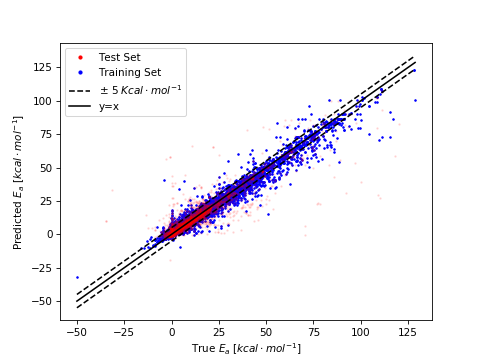

In [17]:
#Test Parity plot
preds = clf.predict(x_test)
preds_2 = clf.predict(x_train)

Xplot = np.array(preds)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4184)
minx,maxx = (min(np.array(y_train)),max(np.array(y_train)))
print()
min_max_linspace = np.linspace(minx*scale,maxx*scale)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,preds_2*scale,c='b', s = 2,alpha=1)

ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.1)
ax.plot(min_max_linspace,min_max_linspace,"k")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)+5,"k--")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)-5,"k--")

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

#legend
colors = ['red', 'blue','black','black']

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.'),
         Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['Test Set', 'Training Set', '$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.legend(lines, labels)
plt.show()


<IPython.core.display.Javascript object>


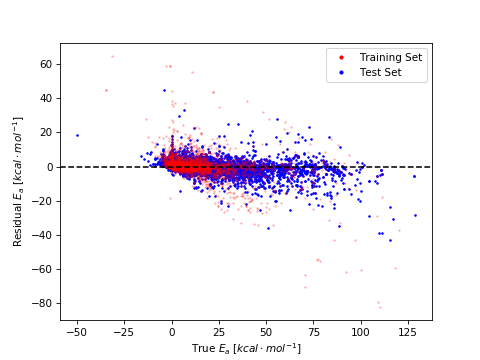

0.9152053807350469 fraction of predictions within 5 Kcal/mol accuracy


In [18]:
#Parity plot Residual
Xplot = np.array(preds) - np.array(y_test)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
scale = (1/4184)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,
         preds_2*scale - np.array(y_train)*scale,
         c='b', s = 2)
ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.2)

plt.ylabel('Residual $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.')]
labels = ['Training Set', 'Test Set']
x_lims = plt.xlim()
plt.hlines(0,x_lims[0], x_lims[1], colors='k', linestyle='--',zorder=np.inf)
plt.xlim(x_lims)
plt.legend(lines, labels)
print(np.sum(Xplot<20920)/len(Xplot),'fraction of predictions within 5 Kcal/mol accuracy')

<IPython.core.display.Javascript object>


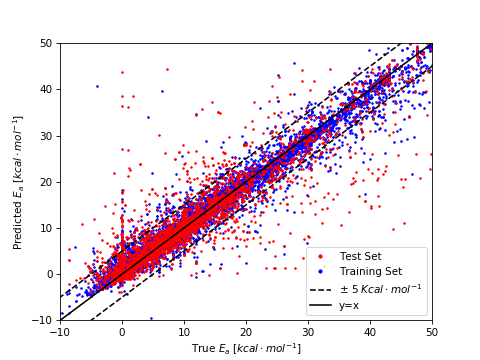

In [19]:
#Zoomed in Parity plot
Xplot = np.array(preds)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4184)
minx,maxx = (min(np.array(y_train)),max(np.array(y_train)))
print()
min_max_linspace = np.linspace(minx*scale,maxx*scale)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,preds_2*scale,c='b', s = 2,alpha=1)

ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.99)
ax.plot(min_max_linspace,min_max_linspace,"k")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)+5,"k--")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)-5,"k--")

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

#legend
colors = ['red', 'blue','black','black']

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.'),
         Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['Test Set', 'Training Set', '$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.xlim((-10,50))
plt.ylim((-10,50))
plt.legend(lines, labels)
plt.show()

# print(clf.score(x_test,y_test), "test")
# print(clf.score(x_train,y_train), 'train')

#len(np.unique(np.array([str(i) for i in X])))
# fig.savefig(fname="test_train_set_all_PP.png")

<IPython.core.display.Javascript object>


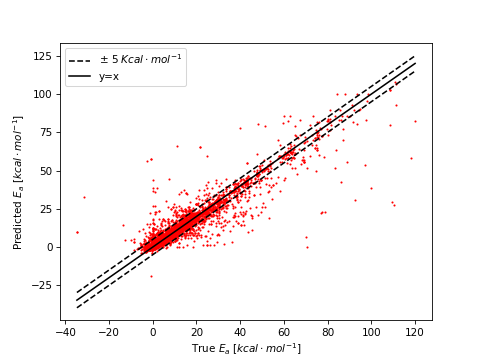

In [20]:
#test Parity plot
Xplot = preds
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4.184)

fig,ax = plt.subplots()

#plt.plot( np.array(y_train)*scale*1e-3,clf.predict(x_train)*scale*1e-3,'b.', markersize = 2)
plt.plot( np.array(Yplot)*scale*1e-3,np.array(Xplot)*scale*1e-3,'r.', markersize = 2)

plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),'k-')
plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3)+5,'k--')
plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3)-5,'k--')

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')
# plt.text(-10, 70, "$R^2 Value :%.3f$"%r_value)
lines = [Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.legend(lines, labels)

# print(clf.score(x_validation,y_validation), "validation")
# print(clf.score(x_train,y_train), 'train')
# fig.savefig(fname="PP_validation_set.png",dpi = 300)
#len(np.unique(np.array([str(i) for i in X])))

<IPython.core.display.Javascript object>


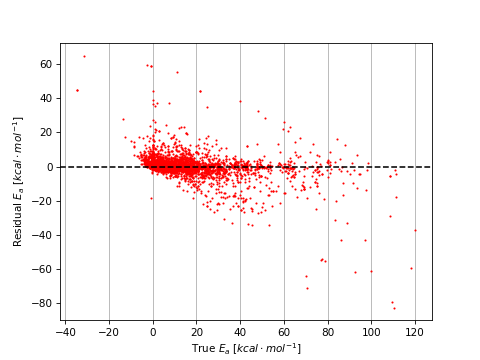

Text(0.5, 0, 'True $E_a$ $[kcal \\cdot mol^{-1}]$')

In [21]:
#Parity plot Residual Validation
Xplot = np.array(preds)- np.array(y_test)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
scale = (1/4.184)*1e-3

fig,ax = plt.subplots()
plt.plot(Yplot*scale,Xplot*scale,'r.', markersize = 2)

x_lims = plt.xlim()
plt.hlines(0,x_lims[0], x_lims[1], colors='k', linestyle='--',zorder=np.inf)
plt.xlim(x_lims)

plt.ylabel('Residual $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')
# fig.savefig(fname="residual_validation_set.png")


In [22]:
#feature importance values
imp = clf.feature_importances_
feat_imp_dict = {'f'+str(+j):imp[j] for j,i in enumerate(imp)}
feat_imp = []
feat_num = []
for i in feat_imp_dict.keys():
    feat_imp.append(feat_imp_dict[i])
    feat_num.append(i)
full_sum = np.sum(feat_imp)
feat_imp = np.array(feat_imp)/np.sum(feat_imp)

118


<IPython.core.display.Javascript object>


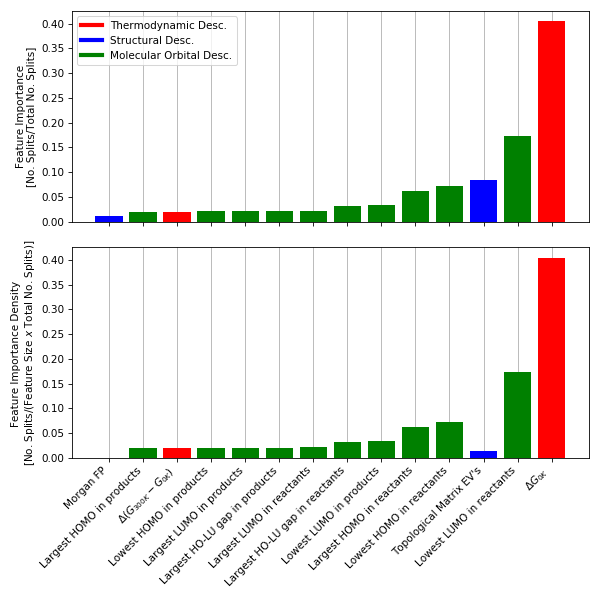

No handles with labels found to put in legend.


In [23]:
#Feature Importance Density
indices_explained = all_data[family]['description_of_feature_indices']
labels = feat_num
label_names = []
for i in labels:
    label_names.append(indices_explained[i.replace('f','')])
labels = np.unique(label_names).tolist()
sums = [0 for i in labels]
feature_sizes = [0 for i in labels]



for j,i in enumerate(indices_explained):
    try:
        name = 'f'+str(j)
        index_sum = labels.index(indices_explained[str(j)])
        sums[index_sum]+=feat_imp_dict[name]/full_sum
        feature_sizes[index_sum]+=1
    except:
        feature_sizes[index_sum]+=1
print(len(feat_imp_dict))
for i in labels.copy():
    ind = labels.index(i)
    if sums[ind]<0.0:
        labels.pop(ind)
        sums.pop(ind)
        feature_sizes.pop(ind)

labels = [i for i in labels]
colorlist = ['g']*len(labels)
feature_dens = [sums[i]/feature_sizes[i] for i in range(len(labels))]

label_importance_tuple = [(sums[i],labels[i],feature_dens[i]) for i in \
                          range(len(labels))]
label_importance_tuple = sorted(label_importance_tuple, key=lambda x:x[0])


labels = [i[1] for i in label_importance_tuple]
feature_dens = [i[2] for i in label_importance_tuple]
colorlist[labels.index("enthalpy")] = 'r'
colorlist[labels.index("entropy")] = 'r'
colorlist[labels.index("morgan")] = 'b'
colorlist[labels.index("topo")] = 'b'
try:
#     colorlist[labels.index("enthalpy")] = 'r'
    labels[labels.index("enthalpy")] = "$\Delta G_{0K}$"
#     colorlist[labels.index("entropy")] = 'r'
    labels[labels.index("entropy")] = "$\Delta (G_{300K} - G_{0K})$"
#     colorlist[labels.index("morgan")] = 'b'
    labels[labels.index("morgan")] = "Morgan FP"
#     colorlist[labels.index("topo")] = 'b'
    labels[labels.index("topo")] = "Topological Matrix EV's"
    
    # labels[labels.index("hom-lum")] = "$\Delta (LUMO-HOMO)$"
    # labels[labels.index("min_lumo_reactants")] = "Max LUMO in reactants"
    # labels[labels.index("min_lumo_reactants")] = "Max LUMO in reactants"
    labels[labels.index("max_lumo_reactants")] = "Largest LUMO in reactants"
    labels[labels.index("min_lumo_reactants")] = "Lowest LUMO in reactants"
    labels[labels.index("max_lumo_products")] = "Largest LUMO in products"
    labels[labels.index("min_lumo_products")] = "Lowest LUMO in products"

    labels[labels.index("max_homo_reactants")] = "Largest HOMO in reactants"
    labels[labels.index("min_homo_reactants")] = "Lowest HOMO in reactants"
    labels[labels.index("max_homo_products")] = "Largest HOMO in products"
    labels[labels.index("min_homo_products")] = "Lowest HOMO in products"

    labels[labels.index("max_h-l_products")] = "Largest HO-LU gap in products"
    labels[labels.index("max_h-l_reactants")] = "Largest HO-LU gap in reactants"
except ValueError:
    labels = [i for i in labels]
    print("labels might be wrong")





sums =  [i[0] for i in label_importance_tuple]

plt.grid(axis='x')
fig, axs = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(8)




axs[0].bar(range(len(labels)), sums, color=colorlist,zorder=3)
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(["" for i in labels])
axs[0].set_ylabel("Feature Importance\n[No. Splits/Total No. Splits]")
axs[0].xaxis.grid()
axs[0].legend()

axs[1].bar(range(len(labels)), feature_dens,color=colorlist,zorder=3)
axs[1].set_xticks(range(len(labels)))
axs[1].xaxis.grid(zorder=0)
axs[1].set_xticklabels(labels,rotation=45,ha='right')
axs[1].set_ylabel("Feature Importance Density \n[No. Splits/(Feature Size $x$ Total No. Splits)]")


custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]

axs[0].legend(custom_lines, ['Thermodynamic Desc.', 'Structural Desc.',
                             'Molecular Orbital Desc.'],loc='upper left',ncol=1)

fig.tight_layout()
# fig.savefig(fname="Feature Importance.png")